In [19]:
# pip install river

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score, precision_score, recall_score, f1_score
import time

In [21]:
def get_data():
    
    df = pd.read_csv("dataverse/rt_8873985678962563_abrupto.csv")
    return df[['X1', 'X2']], df['class']

In [22]:
# Load the dataset
X, y = get_data()

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

In [23]:
# Import the online learning metrics and algorithms from the River library
from river import metrics
from river import stream
from river import tree,neighbors,naive_bayes,ensemble,linear_model
from river.drift import ADWIN
from river.drift.binary import DDM, EDDM
from river import forest

In [24]:
# Define a generic adaptive learning function
# The argument "model" means an online adaptive learning algorithm
def adaptive_learning(model, drift_detector, X_train, y_train, X_test, y_test):
    metric = metrics.Accuracy() # Use accuracy as the metric
    i = 0 # count the number of evaluated data points
    t = [] # record the number of evaluated data points
    m = [] # record the real-time accuracy
    yt = [] # record all the true labels of the test set
    yp = [] # record all the predicted labels of the test set
    
    drift_detect = drift_detector
    print('drift_detector: ', drift_detector)
    
    # Learn the training set
    for xi1, yi1 in stream.iter_pandas(X_train, y_train):
        model.learn_one(xi1,yi1) 

    # Predict the test set
    for xi, yi in stream.iter_pandas(X_test, y_test):
        y_pred= model.predict_one(xi)  # Predict the test sample
        model.learn_one(xi,yi) # Learn the test sample
#         print("yi: "+ str(yi))
#         print("y_pred: "+ str(y_pred))
        metric.update(yi, y_pred) # Update the real-time accuracy
        
        #drift_detection part
#         val = 0
#         if yi != y_pred: 
#             val = 1 
#         in_drift = drift_detect.update(yi)
#         if in_drift:
#             print(f"Change detected at index {i}")

        drift_detect.update(float(yi))
        if drift_detect.drift_detected:
            print(f"Change detected at index {i}")
            if str(drift_detect) != 'EDDM':
                drift_detect.reset()
            
            
#         val = 0
#         if yi != y_pred:
#             val = 1 
#         drift_detect.update(float(val))
#         if drift_detector.drift_detected:
#             print(f"Change detected at index {i}")
        
        t.append(i)
#         print("metric: "+ str(metric))
#         if metric == None:
#             m.append(0*100)
#         else:
#             m.append(metric.get()*100)
            
        m.append(metric.get()*100)
            
        yt.append(yi)
        yp.append(y_pred)
        i = i+1
    print("Accuracy: "+str(round(accuracy_score(yt,yp),4)*100)+"%")
    print("Precision: "+str(round(precision_score(yt,yp),4)*100)+"%")
    print("Recall: "+str(round(recall_score(yt,yp),4)*100)+"%")
    print("F1-score: "+str(round(f1_score(yt,yp),4)*100)+"%")
    return t, m

In [25]:
# Define a figure function that shows the real-time accuracy changes
def acc_fig(t, m, name):
    plt.rcParams.update({'font.size': 15})
    plt.figure(1,figsize=(10,6)) 
    sns.set_style("darkgrid")
    plt.clf() 
    plt.plot(t,m,'-b',label='Avg Accuracy: %.2f%%'%(m[-1]))

    plt.legend(loc='best')
    plt.title(name+' on rt_8873985678962563_abrupto dataset', fontsize=15)
    plt.xlabel('Number of samples')
    plt.ylabel('Accuracy (%)')

    plt.draw()

drift_detector:  DDM
Accuracy: 66.72%
Precision: 67.9%
Recall: 58.099999999999994%
F1-score: 62.62%
CPU times: total: 734 ms
Wall time: 852 ms


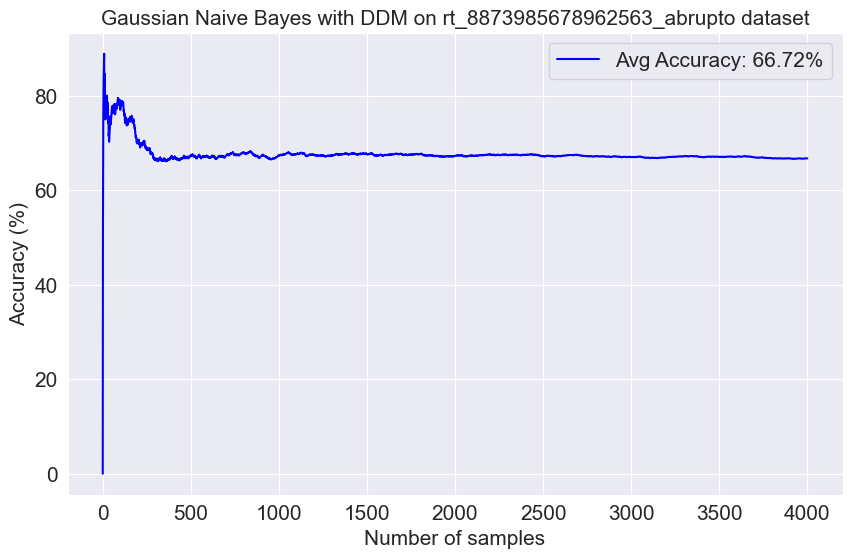

In [26]:
%%time
# Use the Gaussian Naive Bayes as a baseline model
name_01 = "Gaussian Naive Bayes with DDM"
model_01 = naive_bayes.GaussianNB() # Define the model
drift_detector_01 = DDM() # Define the drift detector
t, m_01 = adaptive_learning(model_01, drift_detector_01, X_train, y_train, X_test, y_test) # Learn the model on the dataset
acc_fig(t, m_01, name_01) # Draw the figure of how the real-time accuracy changes with the number of samples

drift_detector:  EDDM
Change detected at index 114
Change detected at index 223
Change detected at index 307
Change detected at index 445
Change detected at index 516
Change detected at index 917
Change detected at index 975
Change detected at index 1070
Change detected at index 1137
Change detected at index 1199
Change detected at index 1302
Change detected at index 1361
Change detected at index 3202
Change detected at index 3271
Change detected at index 3337
Change detected at index 3410
Change detected at index 3509
Change detected at index 3570
Change detected at index 3638
Change detected at index 3731
Change detected at index 3795
Change detected at index 3972
Accuracy: 66.72%
Precision: 67.9%
Recall: 58.099999999999994%
F1-score: 62.62%
CPU times: total: 641 ms
Wall time: 921 ms


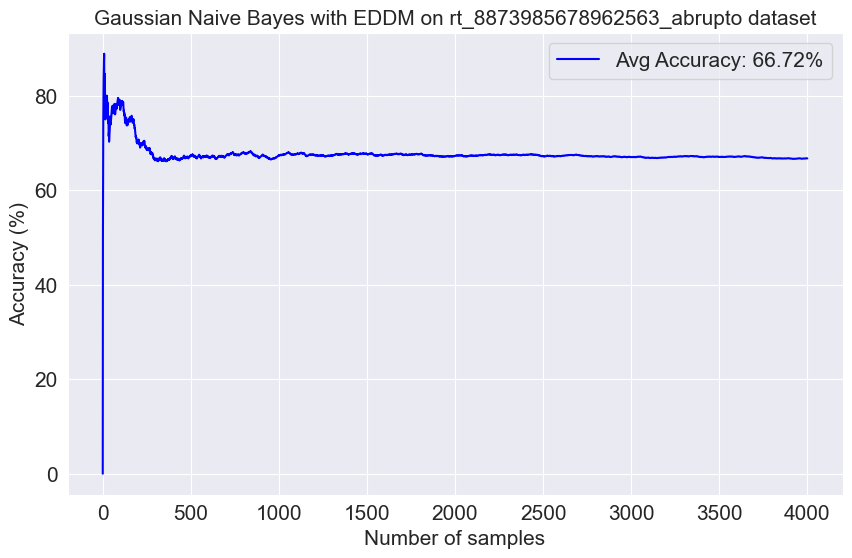

In [27]:
%%time
# Use the Gaussian Naive Bayes as a baseline model
name_02 = "Gaussian Naive Bayes with EDDM"
model_02 = naive_bayes.GaussianNB() # Define the model
drift_detector_02 = EDDM() # Define the drift detector
t, m_02 = adaptive_learning(model_02, drift_detector_02, X_train, y_train, X_test, y_test) # Learn the model on the dataset
acc_fig(t, m_02, name_02) # Draw the figure of how the real-time accuracy changes with the number of samples

drift_detector:  ADWIN
Accuracy: 66.72%
Precision: 67.9%
Recall: 58.099999999999994%
F1-score: 62.62%
CPU times: total: 750 ms
Wall time: 877 ms


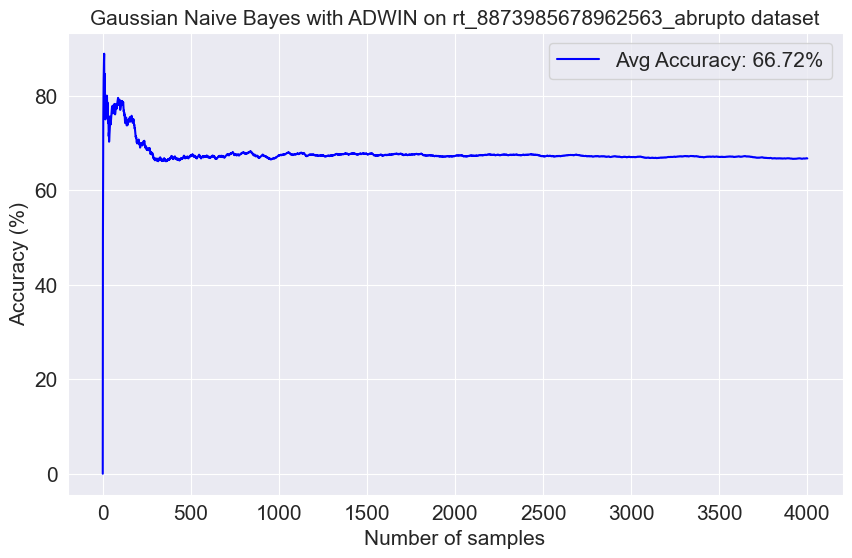

In [28]:
%%time
# Use the Gaussian Naive Bayes as a baseline model
name_03 = "Gaussian Naive Bayes with ADWIN"
model_03 = naive_bayes.GaussianNB() # Define the model
drift_detector_03 = ADWIN() # Define the drift detector
t, m_03 = adaptive_learning(model_03, drift_detector_03, X_train, y_train, X_test, y_test) # Learn the model on the dataset
acc_fig(t, m_03, name_03) # Draw the figure of how the real-time accuracy changes with the number of samples

drift_detector:  DDM
Accuracy: 69.08%
Precision: 67.19000000000001%
Recall: 69.46%
F1-score: 68.31%
CPU times: total: 2.14 s
Wall time: 2.67 s


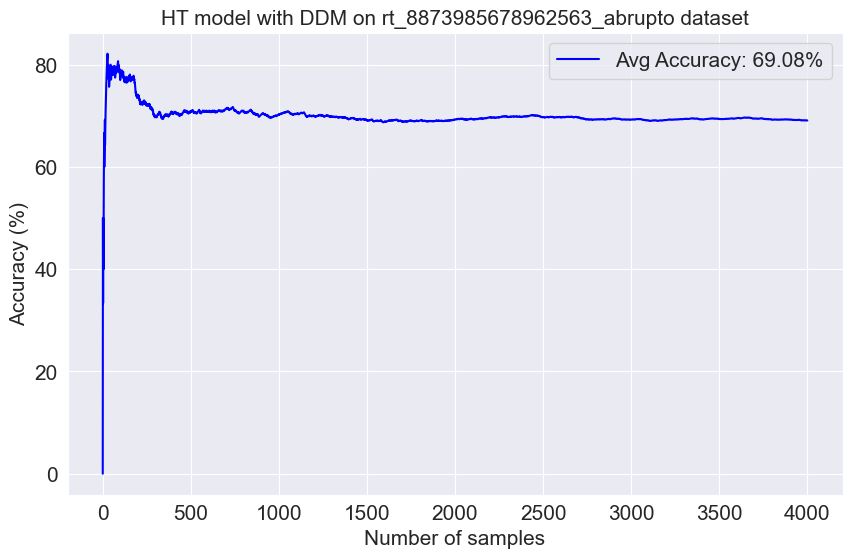

In [29]:
%%time
# Use the Hoeffding Tree (HT) model 
name_04 = "HT model with DDM"
model_04 = tree.HoeffdingTreeClassifier() # Define the model
drift_detector_04 = DDM() # Define the drift detector
t, m_04 = adaptive_learning(model_04, drift_detector_04, X_train, y_train, X_test, y_test) # Learn the model on the dataset
acc_fig(t, m_04, name_04) # Draw the figure of how the real-time accuracy changes with the number of samples

drift_detector:  EDDM
Change detected at index 114
Change detected at index 223
Change detected at index 307
Change detected at index 445
Change detected at index 516
Change detected at index 917
Change detected at index 975
Change detected at index 1070
Change detected at index 1137
Change detected at index 1199
Change detected at index 1302
Change detected at index 1361
Change detected at index 3202
Change detected at index 3271
Change detected at index 3337
Change detected at index 3410
Change detected at index 3509
Change detected at index 3570
Change detected at index 3638
Change detected at index 3731
Change detected at index 3795
Change detected at index 3972
Accuracy: 69.08%
Precision: 67.19000000000001%
Recall: 69.46%
F1-score: 68.31%
CPU times: total: 2.48 s
Wall time: 2.91 s


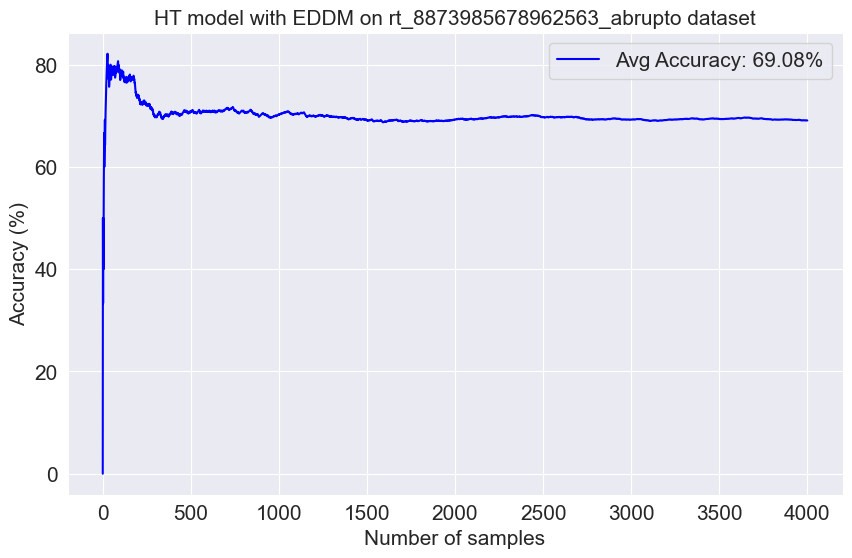

In [30]:
%%time
# Use the Hoeffding Tree (HT) model 
name_05 = "HT model with EDDM"
model_05 = tree.HoeffdingTreeClassifier() # Define the model
drift_detector_05 = EDDM() # Define the drift detector
t, m_05 = adaptive_learning(model_05, drift_detector_05, X_train, y_train, X_test, y_test) # Learn the model on the dataset
acc_fig(t, m_05, name_05) # Draw the figure of how the real-time accuracy changes with the number of samples

drift_detector:  ADWIN
Accuracy: 69.08%
Precision: 67.19000000000001%
Recall: 69.46%
F1-score: 68.31%
CPU times: total: 2.56 s
Wall time: 3.02 s


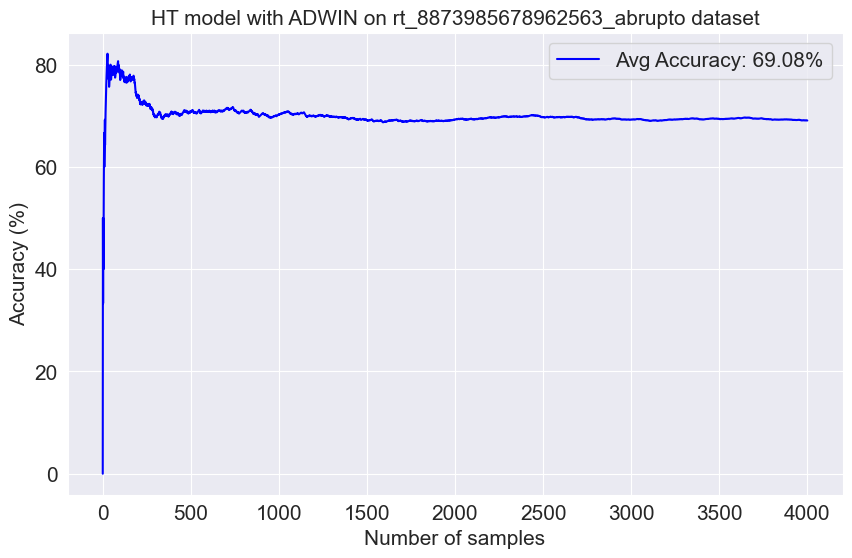

In [31]:
%%time
# Use the Hoeffding Tree (HT) model 
name_06 = "HT model with ADWIN"
model_06 = tree.HoeffdingTreeClassifier() # Define the model
drift_detector_06 = ADWIN() # Define the drift detector
t, m_06 = adaptive_learning(model_06, drift_detector_06, X_train, y_train, X_test, y_test) # Learn the model on the dataset
acc_fig(t, m_06, name_06) # Draw the figure of how the real-time accuracy changes with the number of samples